## Create confound regressors

1. Use Freesurfer segmentation to create white matter and CSF regressors
2. Save into /conf/ subfolder
3. TBD- add global signal and derivatives

In [1]:
# Import nilearn and numpy
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
from nilearn import masking
import numpy as np
import pandas as pd
import glob
from nilearn import signal
from scipy import stats
from scipy import ndimage
import nibabel as nib
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
# install nsdcode by cloning the repository and following the instructions:
# https://github.com/cvnlab/nsdcode/
from nsdcode.nsd_mapdata import NSDmapdata
from nsdcode.nsd_datalocation import nsd_datalocation
from nsdcode.nsd_output import nsd_write_fs
from nsdcode.utils import makeimagestack


In [2]:
# List all paths
import platform
if platform.system() == "Darwin":
    basepath = '/Users/mayayablonski/Sherlock/groupScratch/'
elif platform.system() == "Linux":
    basepath = '/scratch/groups/jyeatman/'
    
basedir = basepath + 'NSD/ppdata/'
fsdir = basepath + 'NSD/nsddata/freesurfer/'
analysisdir = os.path.dirname(os.path.dirname((basedir))) + '/analysis/'
outputdir = analysisdir + 'newlabels/'
nsd_path = basepath + 'NSD/'
#nsd = NSDmapdata(nsd_path)

print(basedir)

/scratch/groups/jyeatman/NSD/ppdata/


In [3]:
# Set parameters
clobber = False
subs = ['subj01','subj02','subj03','subj04','subj05','subj06','subj07','subj08']
doPlot= False
sk=3
erode_iter=4 

In [126]:
subs=subs[0:1]
subs

['subj01']

In [5]:
# aseg.nii.gz labels: from nsddata/templates/FreeSurferColorLUT.txt
# 2 --> Left-Cerebral-White-Matter
# 41 --> Right-Cerebral-White-Matter
# 24 --> CSF
# 4 --> Left-Lateral-Ventricle
# 14 -->3rd-Ventricle
# 15 --> 4th-Ventricle
# 43 --> Right-Lateral-Ventricle

In [78]:
# Create confounds
for s,sub in enumerate(subs):
    fssub = fsdir + sub
    bolddir = basedir + sub + '/func1pt8mm/timeseries/'
    confounddir = basedir + sub + '/func1pt8mm/conf/'
    if not os.path.exists(confounddir):
        os.mkdir(confounddir)
     
    asegpath =  nsd_path+ 'nsddata/ppdata/' + sub +'/func1pt8mm/aseg.nii.gz'
    if not os.path.exists(asegpath):
        print('Cant locate ' + asegpath)
        continue
    else:
        print('Loading ' + asegpath)
        aseg = image.load_img(asegpath)
        if doPlot:
            plotting.plot_anat(aseg)
            # Load mean bold image as background for labels
            bg_path = nsd_path + '/nsddata/ppdata/' + sub +'/func1pt8mm/mean.nii.gz'
            bg = image.load_img(bg_path) 

        aseg_data = aseg.get_fdata()
        # create white matter confound regressor (combine both hemispheres)
        wm_data = np.zeros_like(aseg_data)
        wm_data[aseg_data==2]=1
        wm_data[aseg_data==41]=1
        wm_mask = image.new_img_like(aseg,data=wm_data)
        if doPlot:
            plotting.plot_roi(wm_mask,bg_img=bg,cmap='tab20',cut_coords =[0,0,20])

        # Erode white matter mask to avoid partial volume with gray matter
        wm_erode = ndimage.binary_erosion(wm_data,iterations=erode_iter)
        wm_eroded_mask = image.new_img_like(aseg,data=wm_erode)
        if doPlot:
            plotting.plot_roi(wm_eroded_mask,bg_img=bg,cmap='Accent',cut_coords =[0,0,20])
        
        # create CSF confound regressor   
        csf_data = np.zeros_like(aseg_data)
        csf_data[aseg_data==24]=1
        csf_mask = image.new_img_like(aseg,data=csf_data)
        if doPlot:
            plotting.plot_roi(csf_mask,bg_img=bg,cmap='tab20')

        # create Global Signal regressor
        # I wated to use brainmask.nii.gz but it's much bigger than the breain when overlaid on top of mean.nii.gz
        # so I used aseg instead
        gs_data = np.zeros_like(aseg_data)
        gs_data[aseg_data!=0]=1
        gs_mask = image.new_img_like(aseg,data=gs_data)
        if doPlot:
            plotting.plot_roi(gs_mask,bg_img=bg,cmap='Set1',cut_coords =[0,0,20])
            
        runs = glob.glob(bolddir + '/timeseries*nii.gz')
        runs.sort()
        print('Found ' + str(len(runs)) + ' runs for sub ' + sub)

        for r, run in enumerate(runs):
            boldpath = run
            print('Loading run: ' + run)
            bold = image.load_img(boldpath)
            bold = image.smooth_img(bold, sk)
            
            print('Applying WM mask')
            wm_signal = masking.apply_mask(bold,wm_mask)
            print('White matter timepoints by voxels:')
            print(wm_signal.shape)
            wm_timeseries = np.mean(wm_signal,axis=1)
            # TO DO- DO PCA on WM_SIGNAL - does the function demeans or requires demeaned input? take 2 or 3 PCs
            # erode WM less, maybe iter=2
            
            print('Applying Eroded WM mask')
            wm_signal_e = masking.apply_mask(bold,wm_eroded_mask)
            print('White matter timepoints by voxels:')
            print(wm_signal_e.shape)
            wm_timeseries_e = np.mean(wm_signal_e,axis=1)
            
            print('Applying CSF mask')
            csf_signal = masking.apply_mask(bold,csf_mask)
            print('CSF timepoints by voxels:')
            print(csf_signal.shape)
            csf_timeseries = np.mean(csf_signal,axis=1)
            
            print('Applying Whole Brain mask')
            gs_signal = masking.apply_mask(bold,gs_mask)
            print('GSR timepoints by voxels:')
            print(gs_signal.shape)
            gs_timeseries = np.mean(gs_signal,axis=1)
            
            if doPlot:
                fig, ax = plt.subplots(figsize =(4, 3))
                ax.plot(np.stack((wm_timeseries,wm_timeseries_e,csf_timeseries,gs_timeseries),axis=1))
                r1,p1 = stats.pearsonr(wm_timeseries,csf_timeseries)
                print('WM vs CSF:')
                print(r1, p1)
                r2,p2 = stats.pearsonr(wm_timeseries,wm_timeseries_e)
                print('WM vs Eroded WM:')
                print(r2, p2)
                ax.set_title('Timeseries ' + sub + ' ' + os.path.basename(run))
                ax.set_xlabel('Volume number')
                ax.set_ylabel('Normalized signal')
                ax.legend(['WM','WMe4','CSF','GS'])
                print()

            # Save this as a csv
            confounds = np.stack((wm_timeseries,wm_timeseries_e,csf_timeseries,gs_timeseries),axis=1)
            confounds = pd.DataFrame(confounds)
            confounds.columns=("WM","WMe4","CSF","GSR")

            confound_file = str.replace(run,'timeseries','conf')
            confound_file = str.replace(confound_file,'.nii.gz','.tsv')

            if os.path.exists(confound_file):
                print('Loading existing file: ' + confound_file)
                existing_confounds= pd.read_csv(confound_file,sep='\t',header=0)
                confounds = pd.merge(confounds,existing_confounds,how="left")

            else:
                print('Saving : ' + confound_file)
               
            confounds.to_csv(confound_file,sep='\t',index=False)

Loading /scratch/groups/jyeatman/NSD/nsddata/ppdata/subj07/func1pt8mm/aseg.nii.gz
Found 20 runs for sub subj07
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/timeseries/timeseries_session21_run01.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 61315)
Applying Eroded WM mask
White matter timepoints by voxels:
(226, 2478)
Applying CSF mask
CSF timepoints by voxels:
(226, 140)
Applying Whole Brain mask
GSR timepoints by voxels:
(226, 167486)
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session21_run01.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/timeseries/timeseries_session21_run14.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 61315)
Applying Eroded WM mask
White matter timepoints by voxels:
(226, 2478)
Applying CSF mask
CSF timepoints by voxels:
(226, 140)
Applying Whole Brain mask
GSR timepoints by voxels:
(226, 167486)
Loading existing file: /scratch/groups/jyeat

Applying WM mask
White matter timepoints by voxels:
(226, 61315)
Applying Eroded WM mask
White matter timepoints by voxels:
(226, 2478)
Applying CSF mask
CSF timepoints by voxels:
(226, 140)
Applying Whole Brain mask
GSR timepoints by voxels:
(226, 167486)
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session29_run14.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/timeseries/timeseries_session30_run01.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 61315)
Applying Eroded WM mask
White matter timepoints by voxels:
(226, 2478)
Applying CSF mask
CSF timepoints by voxels:
(226, 140)
Applying Whole Brain mask
GSR timepoints by voxels:
(226, 167486)
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session30_run01.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/timeseries/timeseries_session30_run14.nii.gz
Applying WM mask
White matter timepoints by voxe

Applying WM mask
White matter timepoints by voxels:
(226, 69186)
Applying Eroded WM mask
White matter timepoints by voxels:
(226, 1995)
Applying CSF mask
CSF timepoints by voxels:
(226, 150)
Applying Whole Brain mask
GSR timepoints by voxels:
(226, 198000)
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/conf/conf_session28_run01.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/timeseries/timeseries_session28_run14.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 69186)
Applying Eroded WM mask
White matter timepoints by voxels:
(226, 1995)
Applying CSF mask
CSF timepoints by voxels:
(226, 150)
Applying Whole Brain mask
GSR timepoints by voxels:
(226, 198000)
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/conf/conf_session28_run14.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/timeseries/timeseries_session29_run01.nii.gz
Applying WM mask
White matter timepoints by voxe

In [5]:
# Create columns for derivatives and quadratic terms
for s,sub in enumerate(subs):
    fssub = fsdir + sub
    bolddir = basedir + sub + '/func1pt8mm/timeseries/'
    confounddir = basedir + sub + '/func1pt8mm/conf/'
    basic_confs = ("WMe4","CSF","GSR")
    if not os.path.exists(confounddir):
        os.mkdir(confounddir)
            
    runs = glob.glob(bolddir + '/timeseries*nii.gz')
    runs.sort()
    print('Found ' + str(len(runs)) + ' runs for sub ' + sub)

    for r, run in enumerate(runs):
        boldpath = run

        confound_file = str.replace(run,'timeseries','conf')
        confound_file = str.replace(confound_file,'.nii.gz','.tsv')

        if os.path.exists(confound_file):
            print('Loading existing file: ' + confound_file)
            confounds= pd.read_csv(confound_file,sep='\t',header=0)    
        # create new confounds for each columns
            for conf in basic_confs:
                cur_conf = confounds[conf]
                # using diff shortens the vector by 1 which leads to a mismatch in vector length
                # we have to duplicate the first or last value of the regressor to keep them in the same length
                # not sure if it's better to duplicate the first element (because we throw the first 6 timepoints anyway
                # so there will be no effect for this timepoint), or the last one, to avoid 'pushing' all the data forward
                # cur_diff = np.diff(np.append(cur_con.head(1),cur_con)) 
                cur_diff = np.diff(np.append(cur_conf,cur_conf.tail(1)))
                cur_quad = np.square(cur_conf)
                cur_diffquad = np.square(cur_diff)
                confounds[conf+'_derivative'] = cur_diff
                confounds[conf+'_quadratic'] = cur_quad
                confounds[conf+'_quadratic_derivative'] = cur_diffquad
        else:
            print('Cant locate: ' + confound_file)
            
        # Save this as a csv
        confounds.to_csv(confound_file,sep='\t',index=False)

Found 20 runs for sub subj06
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session21_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session21_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session22_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session22_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session23_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session23_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session24_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session24_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session25_run01.tsv
Loading 

In [9]:
# Load motion regressors, create columns for derivatives and quadratic terms
for s,sub in enumerate(subs):
    fssub = fsdir + sub
    bolddir = basedir + sub + '/func1pt8mm/timeseries/'
    confounddir = basedir + sub + '/func1pt8mm/conf/'
    motiondir = basedir + sub + '/func1pt8mm/motion/'
    
    basic_confs = ('trans_y','trans_x','trans_z', 'rot_x','rot_y','rot_z')
    if not os.path.exists(confounddir):
        os.mkdir(confounddir)
            
    runs = glob.glob(bolddir + '/timeseries*nii.gz')
    runs.sort()
    print('Found ' + str(len(runs)) + ' runs for sub ' + sub)

    for r, run in enumerate(runs):
        boldpath = run

        confound_file = str.replace(run,'timeseries','conf')
        confound_file = str.replace(confound_file,'.nii.gz','.tsv')
        motion_file = str.replace(run,'timeseries','motion')
        motion_file = str.replace(motion_file,'.nii.gz','.tsv')
        print(motion_file)
        if not os.path.exists(motion_file):
            print('Cant locate: ' + motion_file)
            continue
        else:
            print('Loading motion regressors: '+ motion_file)
            motion=pd.read_csv(motion_file,sep='\t',header=None) 
            motion=pd.DataFrame(motion)
            # FIXME - CHECK AGAINST DOCUMENTATION - https://cvnlab.slite.page/p/vjWTghPTb3/Time-series-data 
            motion.columns = ('trans_y','trans_x','trans_z', 'rot_x','rot_y','rot_z')

      
        # create new confounds for each columns
            for conf in basic_confs:
                cur_conf = motion[conf]
                # using diff shortens the vector by 1 which leads to a mismatch in vector length
                # we have to duplicate the first or last value of the regressor to keep them in the same length
                # not sure if it's better to duplicate the first element (because we throw the first 6 timepoints anyway
                # so there will be no effect for this timepoint), or the last one, to avoid 'pushing' all the data forward
                # cur_diff = np.diff(np.append(cur_con.head(1),cur_con)) 
                cur_diff = np.diff(np.append(cur_conf,cur_conf.tail(1)))
                cur_quad = np.square(cur_conf)
                cur_diffquad = np.square(cur_diff)
                motion[conf+'_derivative'] = cur_diff
                motion[conf+'_quadratic'] = cur_quad
                motion[conf+'_quadratic_derivative'] = cur_diffquad
                
        if os.path.exists(confound_file):
            print('Loading existing file: ' + confound_file)
            confounds= pd.read_csv(confound_file,sep='\t',header=0)
            confounds = confounds.join(motion)
        else:
            print('Cant locate: ' + confound_file)
            
        # Save this as a csv
        confounds.to_csv(confound_file,sep='\t',index=False)

Found 20 runs for sub subj01
/scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session21_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session21_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/conf/conf_session21_run01.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session21_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session21_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/conf/conf_session21_run14.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session22_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session22_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/conf/conf_session22_run01.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj0

/scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session25_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session25_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/conf/conf_session25_run01.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session25_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session25_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/conf/conf_session25_run14.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session26_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session26_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/conf/conf_session26_run01.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_se

Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/conf/conf_session28_run14.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session29_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session29_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/conf/conf_session29_run01.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session29_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session29_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/conf/conf_session29_run14.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session30_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session30_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj03/func

Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/conf/conf_session22_run14.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session23_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session23_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/conf/conf_session23_run01.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session23_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session23_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/conf/conf_session23_run14.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session24_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session24_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj05/func

Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session26_run01.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session26_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session26_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session26_run14.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session27_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session27_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session27_run01.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session27_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session27_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func

/scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/motion/motion_session29_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/motion/motion_session29_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session29_run14.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/motion/motion_session30_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/motion/motion_session30_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session30_run01.tsv
/scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/motion/motion_session30_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/motion/motion_session30_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session30_run14.tsv
Found 20 runs for sub subj08
/scratch/groups/jyeatman/NSD/ppdata/subj0

Found 20 runs for sub subj01
/scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session21_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session21_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/conf/conf_session21_run01.tsv
found 0 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session21_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session21_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/conf/conf_session21_run14.tsv
found 1 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session22_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/motion/motion_session22_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj01/func1pt8mm/conf/conf_session22_r

/tmp/ipykernel_4406/1931784349.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize =(4, 3))


/scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session23_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session23_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/conf/conf_session23_run14.tsv
found 24 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session24_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session24_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/conf/conf_session24_run01.tsv
found 2 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session24_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/motion/motion_session24_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj02/func1pt8mm/conf/conf_session24_run14.tsv
found 5 volumes to 

/scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session27_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session27_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/conf/conf_session27_run01.tsv
found 0 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session27_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session27_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/conf/conf_session27_run14.tsv
found 1 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session28_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/motion/motion_session28_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj03/func1pt8mm/conf/conf_session28_run01.tsv
found 0 volumes to s

found 24 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session22_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session22_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/conf/conf_session22_run01.tsv
found 23 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session22_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session22_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/conf/conf_session22_run14.tsv
found 14 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session23_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/motion/motion_session23_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/conf/conf_session23_ru

found 3 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session27_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session27_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session27_run01.tsv
found 0 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session27_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session27_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session27_run14.tsv
found 0 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session28_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/motion/motion_session28_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session28_run01

/scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/motion/motion_session30_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/motion/motion_session30_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session30_run01.tsv
found 0 volumes to scrub
/scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/motion/motion_session30_run14.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/motion/motion_session30_run14.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session30_run14.tsv
found 1 volumes to scrub
Found 20 runs for sub subj08
/scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/motion/motion_session21_run01.tsv
Loading motion regressors: /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/motion/motion_session21_run01.tsv
Loading existing file: /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/conf/conf_session21_r

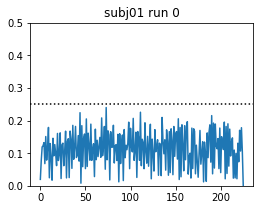

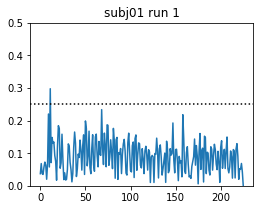

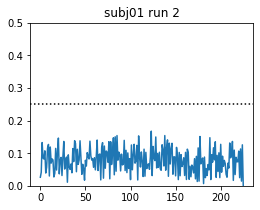

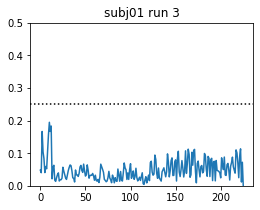

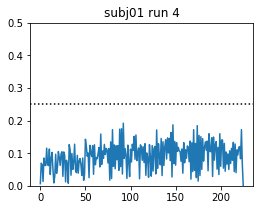

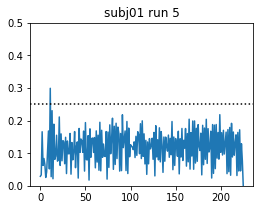

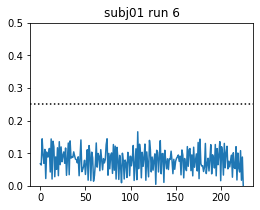

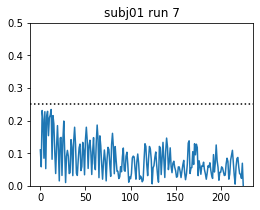

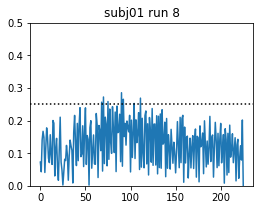

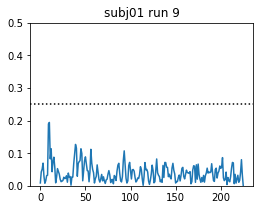

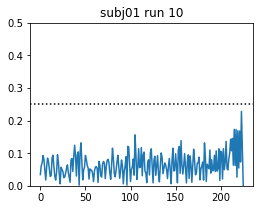

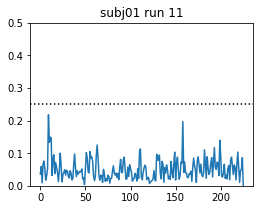

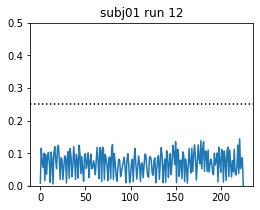

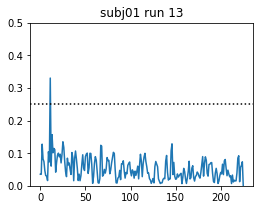

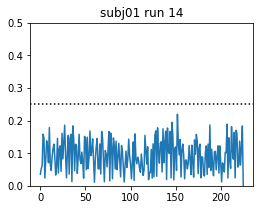

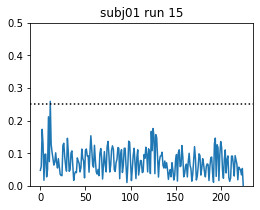

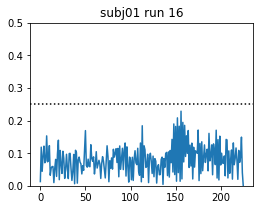

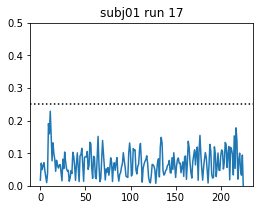

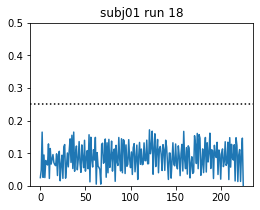

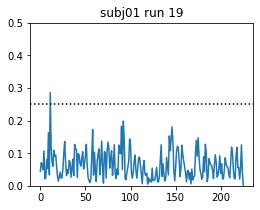

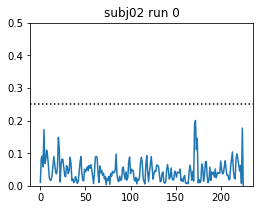

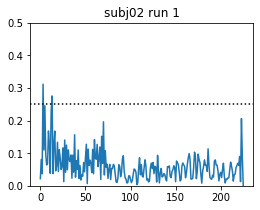

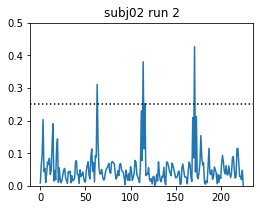

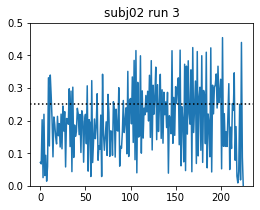

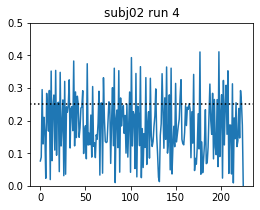

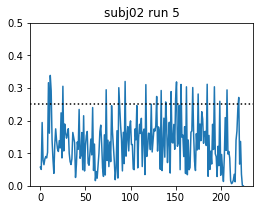

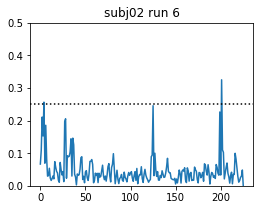

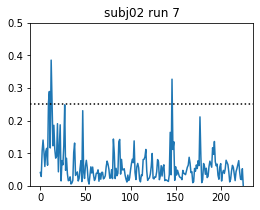

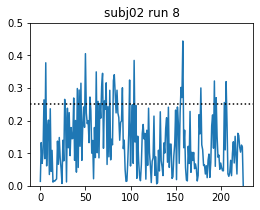

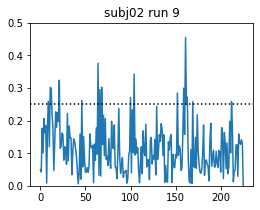

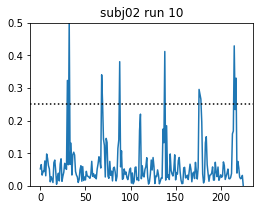

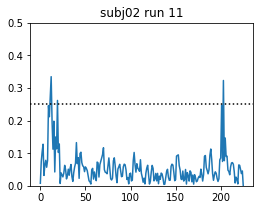

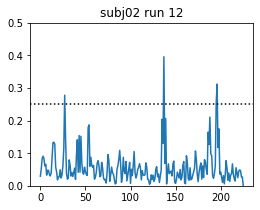

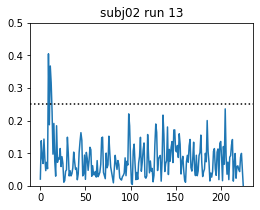

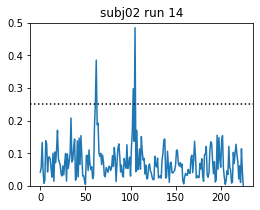

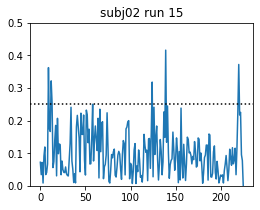

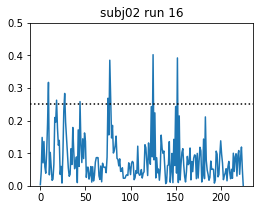

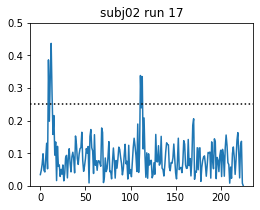

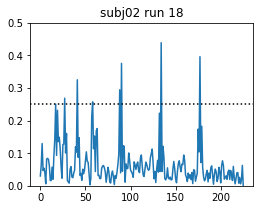

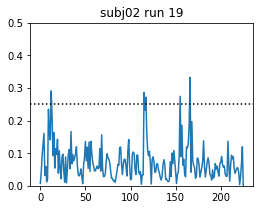

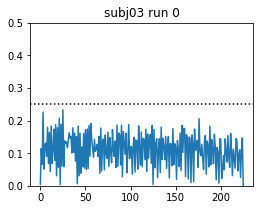

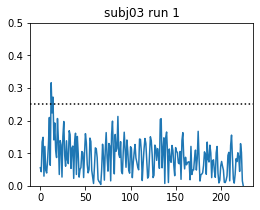

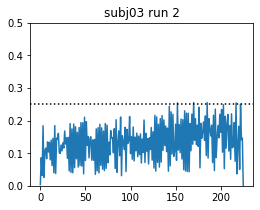

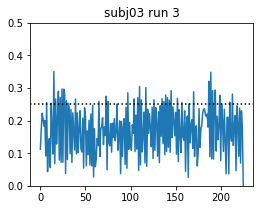

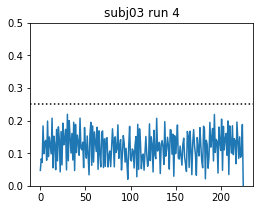

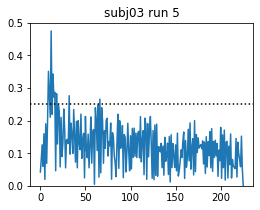

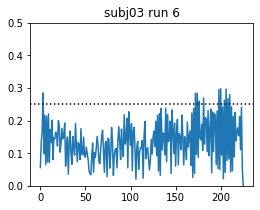

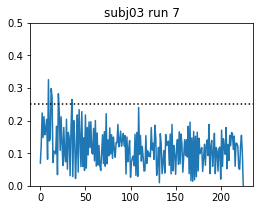

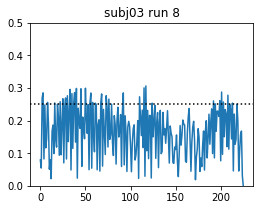

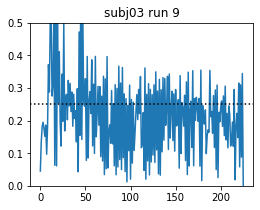

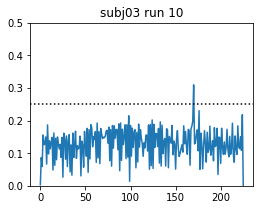

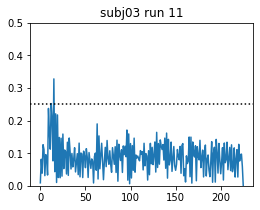

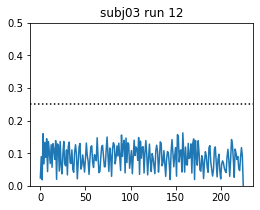

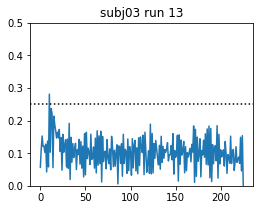

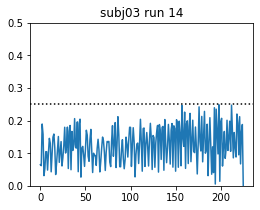

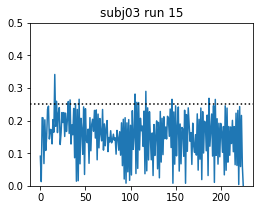

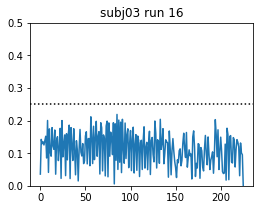

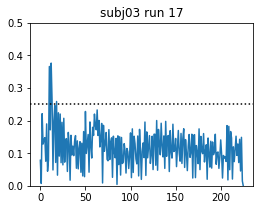

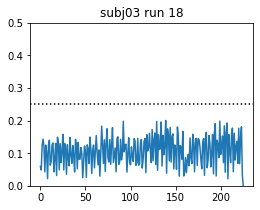

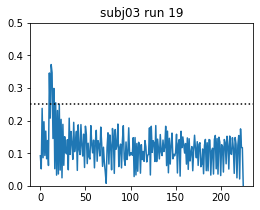

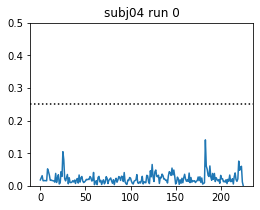

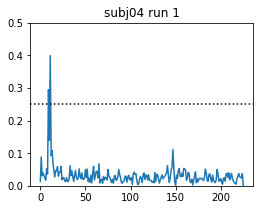

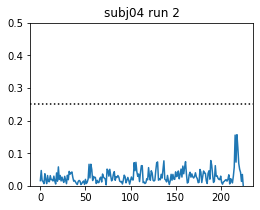

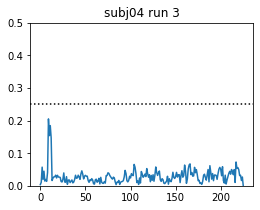

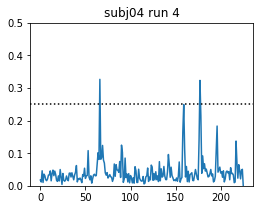

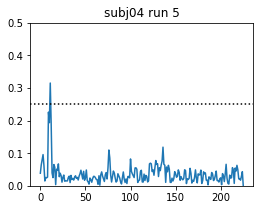

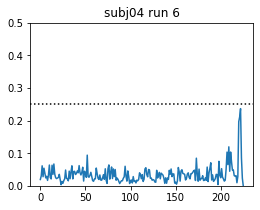

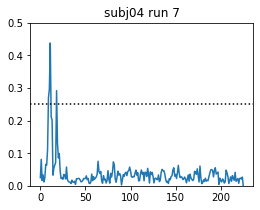

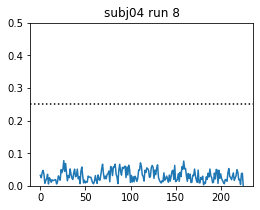

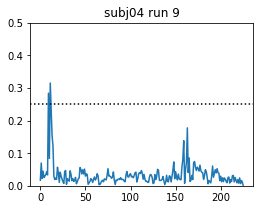

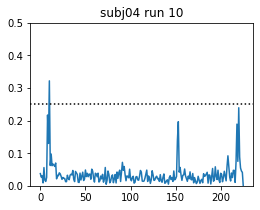

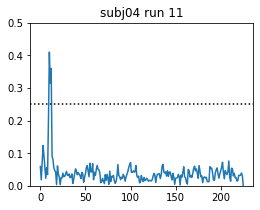

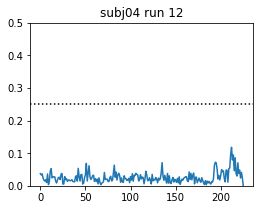

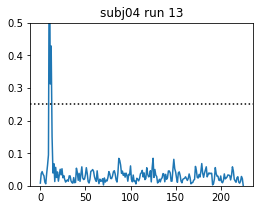

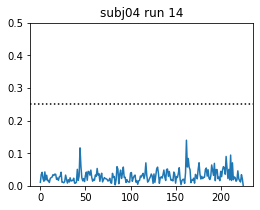

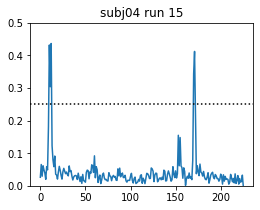

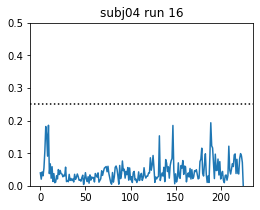

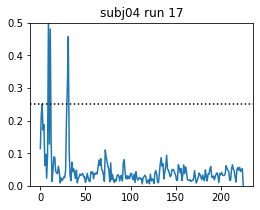

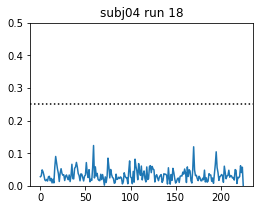

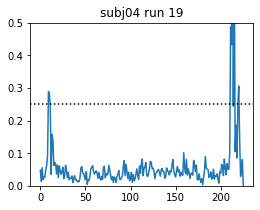

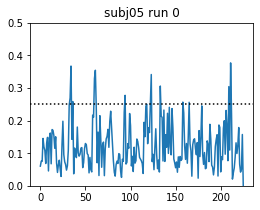

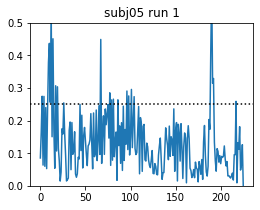

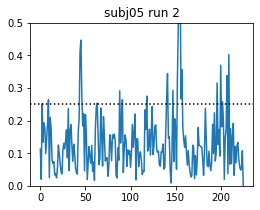

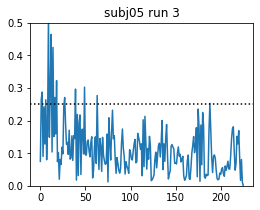

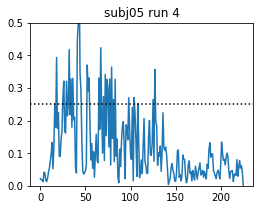

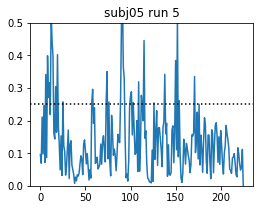

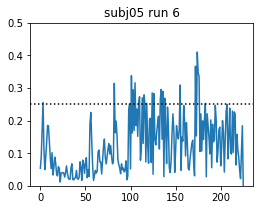

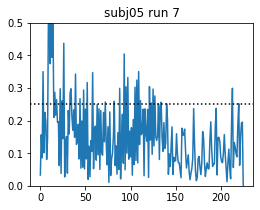

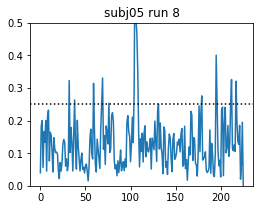

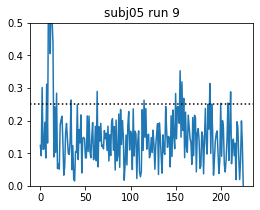

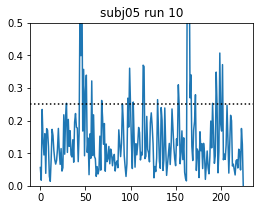

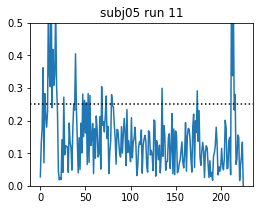

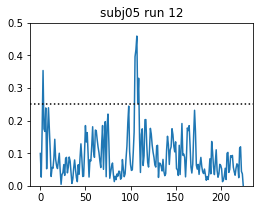

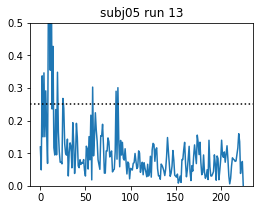

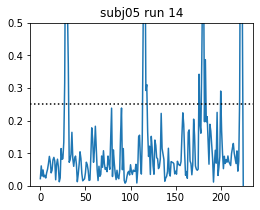

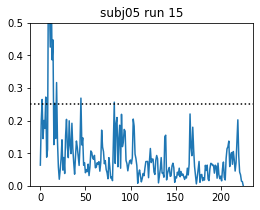

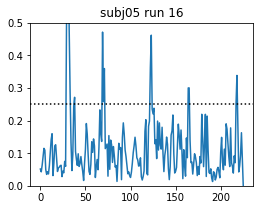

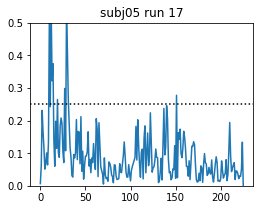

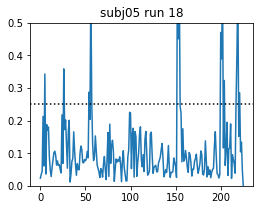

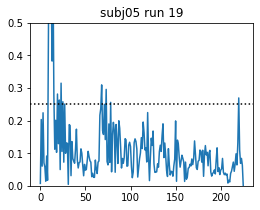

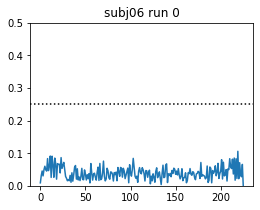

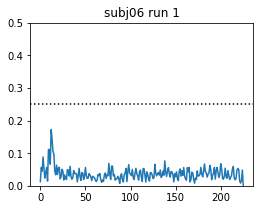

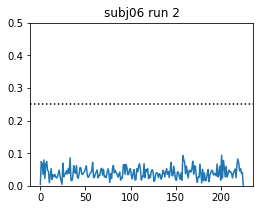

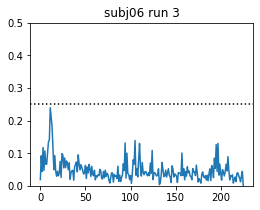

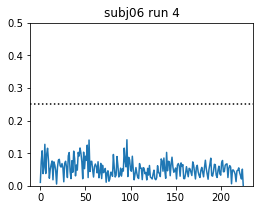

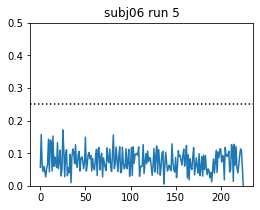

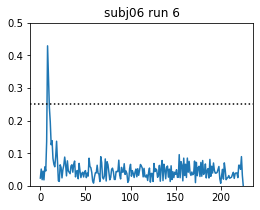

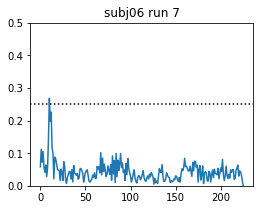

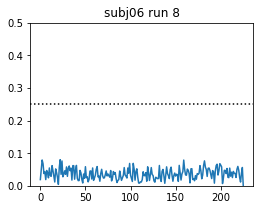

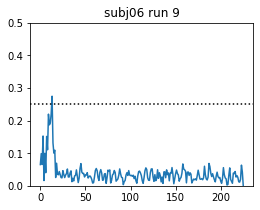

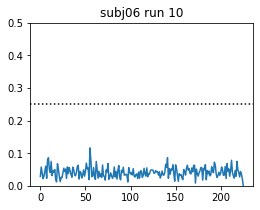

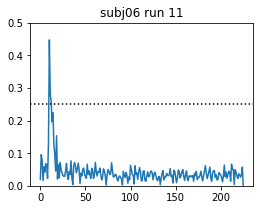

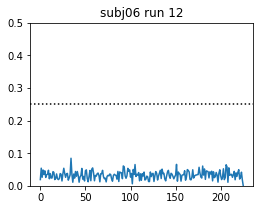

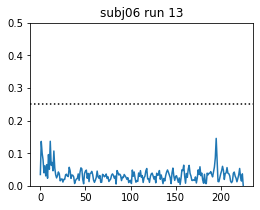

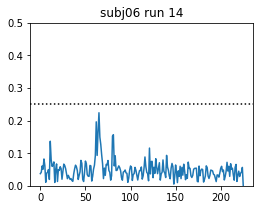

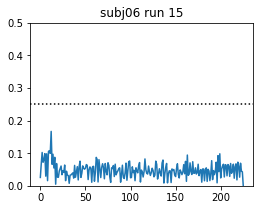

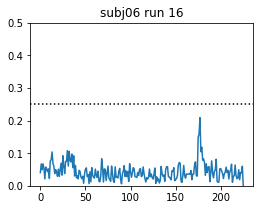

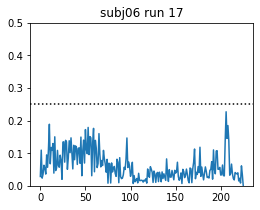

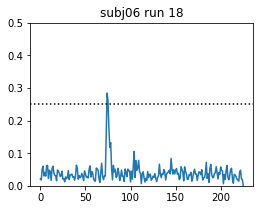

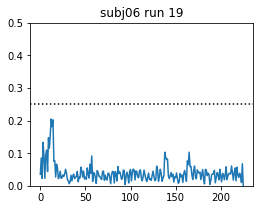

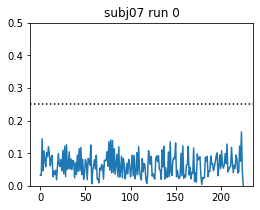

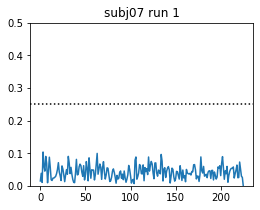

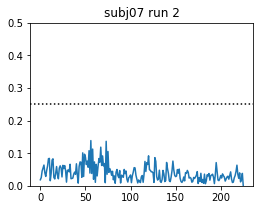

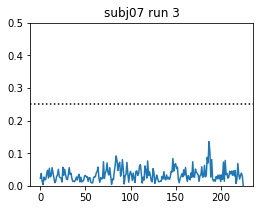

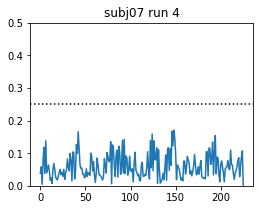

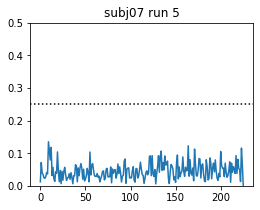

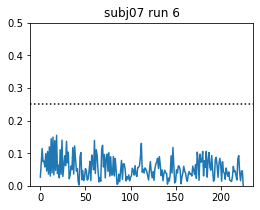

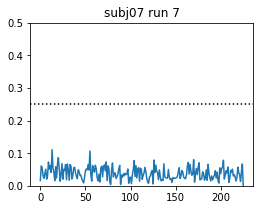

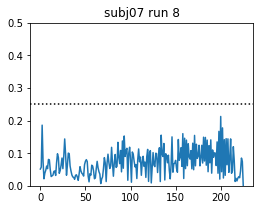

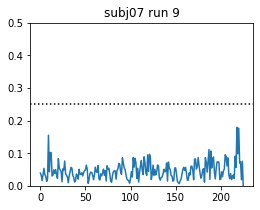

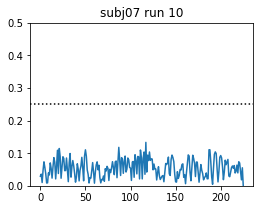

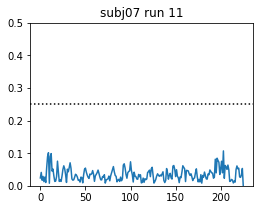

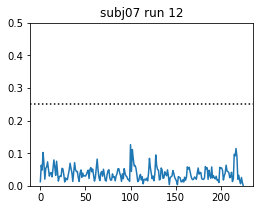

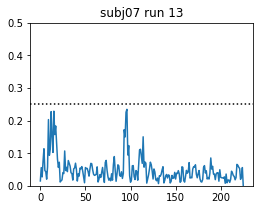

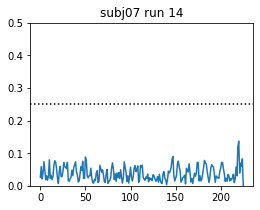

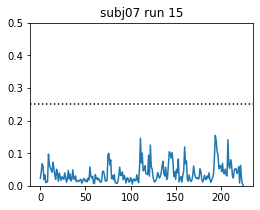

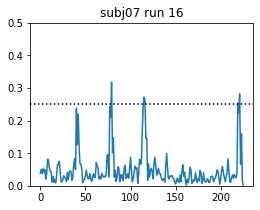

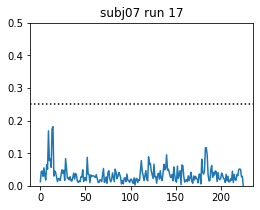

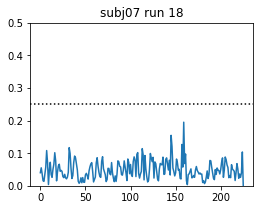

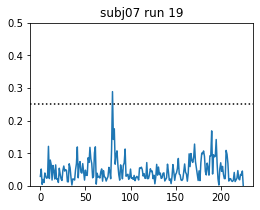

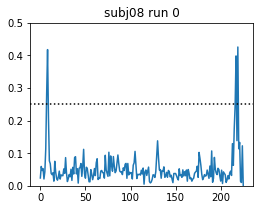

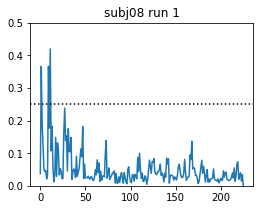

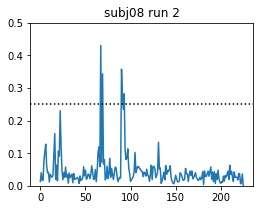

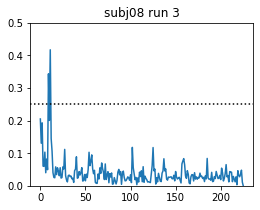

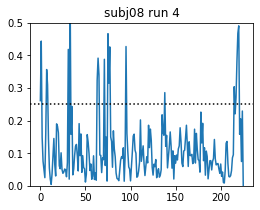

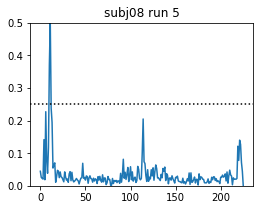

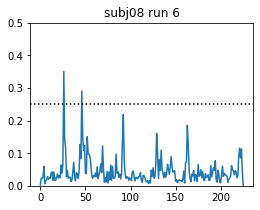

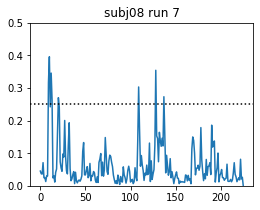

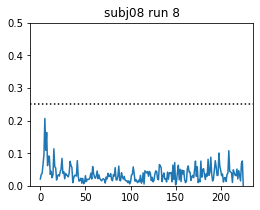

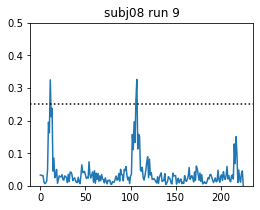

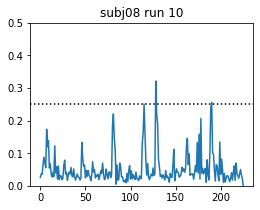

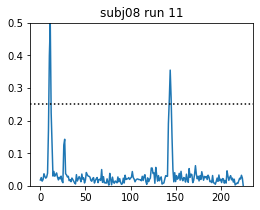

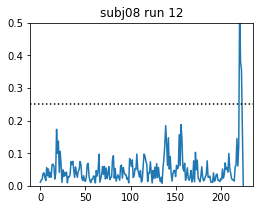

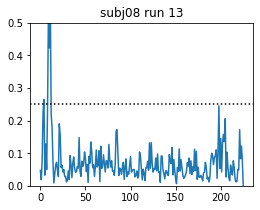

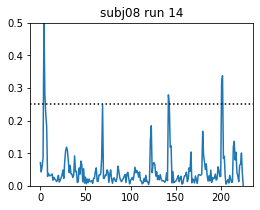

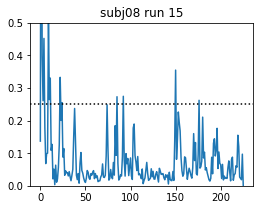

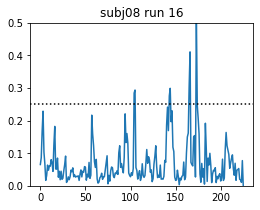

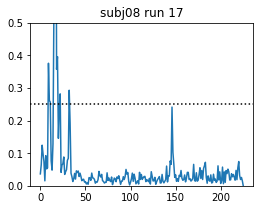

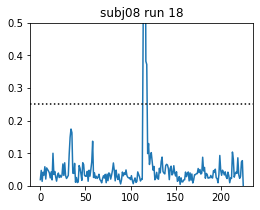

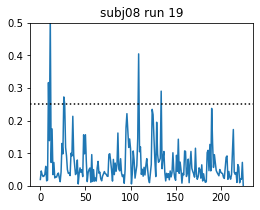

In [24]:
# Load motion regressors, calculate FD
fd_thresh = 0.25 # Following Ciric 2017 and Power 2018
qc = pd.DataFrame(columns=('meanFD','medianFD','maxFD','numVols'),index=range(len(subs)*20))
for s,sub in enumerate(subs):
    fssub = fsdir + sub
    bolddir = basedir + sub + '/func1pt8mm/timeseries/'
    confounddir = basedir + sub + '/func1pt8mm/conf/'
    motiondir = basedir + sub + '/func1pt8mm/motion/'
    
    basic_confs = ('trans_y','trans_x','trans_z', 'rot_x','rot_y','rot_z')
    if not os.path.exists(confounddir):
        os.mkdir(confounddir)
            
    runs = glob.glob(bolddir + '/timeseries*nii.gz')
    runs.sort()
    print('Found ' + str(len(runs)) + ' runs for sub ' + sub)

    for r, run in enumerate(runs):
        boldpath = run
        
        confound_file = str.replace(run,'timeseries','conf')
        confound_file = str.replace(confound_file,'.nii.gz','.tsv')
        motion_file = str.replace(run,'timeseries','motion')
        motion_file = str.replace(motion_file,'.nii.gz','.tsv')
        print(motion_file)
        if not os.path.exists(motion_file):
            print('Cant locate: ' + motion_file)
            continue
        else:
            print('Loading motion regressors: '+ motion_file)
            motion=pd.read_csv(motion_file,sep='\t',header=None) 
            motion=pd.DataFrame(motion)
            # FIXME - CHECK AGAINST DOCUMENTATION - https://cvnlab.slite.page/p/vjWTghPTb3/Time-series-data 
            motion.columns = ('trans_y','trans_x','trans_z', 'rot_x','rot_y','rot_z')

            if not os.path.exists(confound_file):
                print('Cant locate: ' + confound_file)
                continue
            else:
                print('Loading existing file: ' + confound_file)
                confounds= pd.read_csv(confound_file,sep='\t',header=0)
                # duplicate the last row to calculate the derivatives without shortening the vector
                last_values = pd.DataFrame(motion.iloc[-1]).transpose() 
                motion = pd.concat([motion,last_values], axis=0)
                FD_calc = motion.apply(np.diff)
                FD_calc = FD_calc.abs()
                motion['FD'] = FD_calc.sum(axis=1)
                # dont need this last row anymore so we drop it to return to original dimensions
                motion = motion.head(motion.shape[0] -1)
                fig, ax = plt.subplots(figsize =(4, 3))
                plt.plot(motion.FD)
                plt.ylim(0,0.5)
                plt.axhline(y=0.25,linestyle=":",color='black')
                plt.title(sub + ' run ' + str(r))
    
                # metrics for group QC csv
                vols_to_scrub = motion.loc[motion['FD'] > fd_thresh, 'FD']
                vols_to_scrub.shape[0]
                cur_ind = r + s*len(runs)
                qc.loc[cur_ind,'subj'] = sub
                qc.loc[cur_ind,'run'] = os.path.basename(run)
                qc.loc[cur_ind,'run_id'] = r
                qc.loc[cur_ind,'meanFD'] = motion.FD.mean()   
                qc.loc[cur_ind,'medianFD'] = motion.FD.median()   
                qc.loc[cur_ind,'maxFD'] = motion.FD.max()
                qc.loc[cur_ind,'numVols'] = vols_to_scrub.shape[0] 
                # mark runs for exclusion - runs that have too many noisy volumes or too large meanFD 
                qc.loc[cur_ind,'exclude'] = np.logical_or(vols_to_scrub.shape[0]>=(motion.shape[0]-6)*.1,motion.FD.mean() > fd_thresh) 

                # create single regressors for each 'bad' volume
                idxs = motion.index[motion['FD']>fd_thresh]
                print('found '+ str(len(idxs)) + ' volumes to scrub')
                for idx in range(len(idxs)):
                    confounds['scrub_'+str(idx)] = np.zeros(motion.shape[0])
                    confounds.loc[idxs[idx],'scrub_'+str(idx)]=1

                # Save this as a csv
                confounds.to_csv(confound_file,sep='\t',index=False)

# write qc dataframe                
qc.to_csv(basedir + 'QC_FD025.csv',sep='\t',index=False)               
    

In [16]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3):
    print(qc)

    meanFD medianFD  maxFD numVols    subj                                run  \
0    0.113    0.119   0.24       0  subj01  timeseries_session21_run01.nii.gz   
1     0.09    0.091  0.298       1  subj01  timeseries_session21_run14.nii.gz   
2    0.078    0.079  0.168       0  subj01  timeseries_session22_run01.nii.gz   
3    0.048    0.041  0.195       0  subj01  timeseries_session22_run14.nii.gz   
4     0.09    0.093  0.192       0  subj01  timeseries_session23_run01.nii.gz   
5    0.117    0.119  0.299       1  subj01  timeseries_session23_run14.nii.gz   
6    0.077    0.081  0.166       0  subj01  timeseries_session24_run01.nii.gz   
7     0.08    0.069  0.234       0  subj01  timeseries_session24_run14.nii.gz   
8    0.127    0.128  0.285       7  subj01  timeseries_session25_run01.nii.gz   
9     0.04    0.034  0.194       0  subj01  timeseries_session25_run14.nii.gz   
10   0.065     0.06  0.228       0  subj01  timeseries_session26_run01.nii.gz   
11    0.05    0.042  0.218  

In [25]:
exclude_runs = pd.DataFrame(qc.groupby('subj')['exclude'].apply(lambda x: (x==True).sum()))
exclude_runs

,exclude
subj,
subj01,0
subj02,4
subj03,3
subj04,0
subj05,9
subj06,0
subj07,0
subj08,0


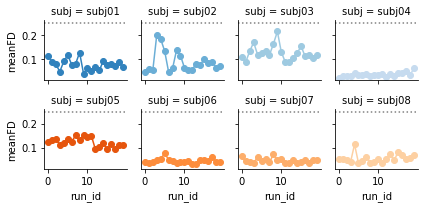

In [178]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(qc, col="subj", hue="subj", palette="tab20c",
                     col_wrap=4, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=0.25, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "run_id", "meanFD", marker="o")


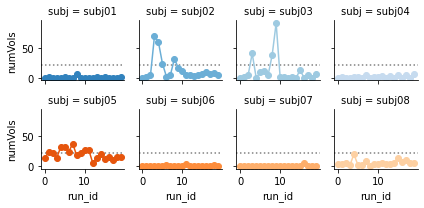

In [154]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(qc, col="subj", hue="subj", palette="tab20c",
                     col_wrap=4, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=22, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "run_id", "numVols", marker="o")

In [6]:
# For testing and debugging
motion_file = basedir + 'subj01/func1pt8mm/motion/motion_session09_run04.tsv'
motion=pd.read_csv(motion_file,sep='\t',header=None) 
motion=pd.DataFrame(motion)
# FIXME - CHECK AGAINST DOCUMENTATION - https://cvnlab.slite.page/p/vjWTghPTb3/Time-series-data 
motion.columns = ('trans_y','trans_x','trans_z', 'rot_x','rot_y','rot_z')
last_values = pd.DataFrame(motion.iloc[-1]).transpose() 
motion = pd.concat([motion,last_values], axis=0)
FD_calc = motion.apply(np.diff)
FD_calc = FD_calc.abs()
motion['FD'] = FD_calc.sum(axis=1)
# drop last row 
motion = motion.head(motion.shape[0] -1)

fig, ax = plt.subplots(figsize =(4, 3))
plt.plot(motion.FD)
plt.ylim(0,0.5)
plt.axhline(y=0.25,linestyle=":",color='black')
plt.title(sub + ' run '+ str(r))
# idxs = motion.index[motion['FD']>fd_thresh]
# print('found '+ str(len(idxs)) + ' volumes to scrub')
# for idx in range(len(idxs)):
#     motion['scrub_'+str(idx)] = np.zeros(motion.shape[0])
#     motion.loc[idxs[idx],'scrub_'+str(idx)]=1

In [203]:
motion

,trans_y,trans_x,trans_z,rot_x,rot_y,rot_z,FD,scrub_0,scrub_1,scrub_2,scrub_3,scrub_4,scrub_5
0,0.504924,0.252685,-1.405335,0.001976,0.005595,-0.002492,0.019398,0.0,0.0,0.0,0.0,0.0,0.0
1,0.508718,0.254644,-1.392274,0.002048,0.005097,-0.002477,0.045474,0.0,0.0,0.0,0.0,0.0,0.0
2,0.505242,0.263590,-1.360260,0.002275,0.004398,-0.002588,0.033986,0.0,0.0,0.0,0.0,0.0,0.0
3,0.524252,0.262603,-1.347225,0.002365,0.003557,-0.002611,0.028368,0.0,0.0,0.0,0.0,0.0,0.0
4,0.513748,0.259468,-1.332635,0.002441,0.003554,-0.002551,0.029722,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,0.438327,0.241858,-0.843524,-0.001391,-0.016686,-0.002258,0.009365,0.0,0.0,0.0,0.0,0.0,0.0
222,0.437126,0.239127,-0.848487,-0.001589,-0.016526,-0.002147,0.021134,0.0,0.0,0.0,0.0,0.0,0.0
223,0.426577,0.238904,-0.838758,-0.001857,-0.016276,-0.002032,0.020105,0.0,0.0,0.0,0.0,0.0,0.0
224,0.438117,0.238200,-0.846098,-0.002096,-0.015999,-0.002036,0.071800,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
motion.loc[motion['FD']>fd_thresh]

,trans_y,trans_x,trans_z,rot_x,rot_y,rot_z,FD
9,0.507430,0.278378,-1.301992,0.002386,0.001134,-0.002954,0.316529
11,0.721595,0.303779,-1.330447,0.003213,0.000243,-0.003830,0.517749
26,0.481376,0.310097,-1.434339,0.002295,-0.003658,-0.003688,0.272463
27,0.644636,0.297634,-1.341055,0.001477,-0.006160,-0.003551,0.251316
109,0.629505,0.342665,-1.271774,-0.000638,-0.019665,-0.005388,0.404464
134,0.368873,0.282047,-1.549824,-0.001804,-0.015885,-0.003412,0.290227


In [190]:
idxs = motion.index[motion['FD']>fd_thresh]

In [195]:
test = motion.loc[scrub==1,:]
test

,trans_y,trans_x,trans_z,rot_x,rot_y,rot_z,FD
9,0.507430,0.278378,-1.301992,0.002386,0.001134,-0.002954,0.316529
11,0.721595,0.303779,-1.330447,0.003213,0.000243,-0.003830,0.517749
26,0.481376,0.310097,-1.434339,0.002295,-0.003658,-0.003688,0.272463
27,0.644636,0.297634,-1.341055,0.001477,-0.006160,-0.003551,0.251316
109,0.629505,0.342665,-1.271774,-0.000638,-0.019665,-0.005388,0.404464
134,0.368873,0.282047,-1.549824,-0.001804,-0.015885,-0.003412,0.290227


### TEST ROI Erosion

In [9]:
from scipy import ndimage
iter=3
wm_erode = ndimage.binary_erosion(wm_data,iterations=iter)

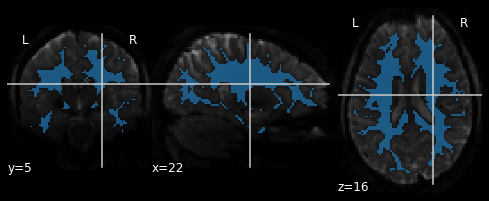

In [7]:
# iter=1
plotting.plot_roi(wm_eroded_mask,bg_img=bg,cmap='tab20')

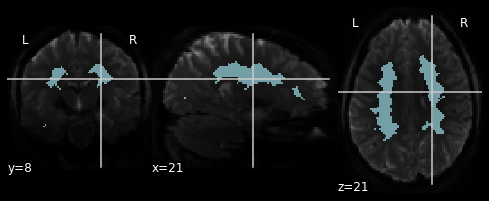

In [10]:
# iter=3
plotting.plot_roi(wm_eroded_mask,bg_img=bg,cmap='tab20_r')

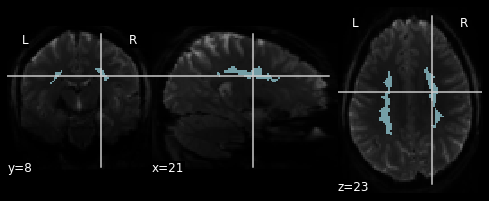

In [13]:
#iter=5 --> 
plotting.plot_roi(wm_eroded5_mask,bg_img=bg,cmap='tab20_r')

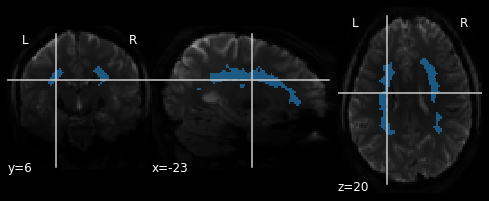

In [15]:
# iter=4--> Power 2017 Neuroimage
iter=4
wm_erode = ndimage.binary_erosion(wm_data,iterations=iter)
wm_eroded_mask = image.new_img_like(aseg,data=wm_erode)
plotting.plot_roi(wm_eroded_mask,bg_img=bg,cmap='tab10')